In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones

In [3]:
style.use('default')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Set parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006

place_name = 'Barcelona'
local_crs = 'EPSG:25830'

In [5]:
# walkshed distances in meters and associated colors for figures
# minimum park area in sq.m. (e.g. 0.5 hectare equals 5000 square meters)

trip_distances = [300, 500, 800]
trip_colors = ['#78c679', '#c2e699', '#ffffcc']
min_area = 5000

# Load data

In [6]:
# load boundaries of place and create buffer zone around it for analysis purposes
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

buffer = max(trip_distances)
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

In [7]:
# all roads suitable for pedestrians
G = ox.graph_from_polygon(extent_shape, network_type='walk', retain_all=True)
paths = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)

In [8]:
# all leisure areas tagged as parks
park_query = '["leisure"~"^(park)"]'
parks = get_osm_data(park_query, extent, 'convexhull')

In [9]:
# all buildings with or without any tags
build_query = '[building]'
buildings = get_osm_data(build_query, extent, 'convexhull')

Ways not found
Relation not converted to feature {'type': 'relation', 'id': 4251286, 'bounds': {'minlat': 41.3213032, 'minlon': 2.105663, 'maxlat': 41.3213231, 'maxlon': 2.1056999}, 'members': [{'type': 'way', 'ref': 315952460, 'role': 'inner', 'geometry': [{'lat': 41.3213032, 'lon': 2.1056999}, {'lat': 41.3213231, 'lon': 2.1056837}, {'lat': 41.3213118, 'lon': 2.105663}], 'used': 4251286}], 'tags': {'building': 'yes', 'type': 'multipolygon'}}
Element not converted {'type': 'relation', 'id': 4251286, 'bounds': {'minlat': 41.3213032, 'minlon': 2.105663, 'maxlat': 41.3213231, 'maxlon': 2.1056999}, 'members': [{'type': 'way', 'ref': 315952460, 'role': 'inner', 'geometry': [{'lat': 41.3213032, 'lon': 2.1056999}, {'lat': 41.3213231, 'lon': 2.1056837}, {'lat': 41.3213118, 'lon': 2.105663}], 'used': 4251286}], 'tags': {'building': 'yes', 'type': 'multipolygon'}}
multipolygon member not handled {'type': 'node', 'ref': 5174498688, 'role': '', 'lat': 41.4063295, 'lon': 2.1669313}
Ways not found
R

# Filter greenspaces

In [10]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=10000, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area > 0:
        filtered = filtered[filtered.geometry.area>=min_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [11]:
# filter to include only parks larger than minimum area
# and intersection with the pedestrian road network (i.e. accessible by foot)
parks = greenspace_filter(parks, local_crs, min_area=min_area, G=G)
'{} parks fulfil the criteria for filtering'.format(len(parks))

'194 parks fulfil the criteria for filtering'

## Calculate walkshed areas (isochrones)

In [12]:
# calculate walkshed isochrones for all trip distances
get_isochrones(G, parks, trip_distances, local_crs)

## Plot outcomes

In [13]:
# create legend
legend_handles = [
    mpatches.Patch(color='#006837', label='Park (>{} sq.m.)'.format(min_area)),
    mpatches.Patch(color=trip_colors[0], label='Within 300m (5min) walk'),
    mpatches.Patch(color=trip_colors[1], label='Within 500m (10min) walk'),
    mpatches.Patch(color=trip_colors[2], label='Within 800m (15min) walk'),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
]

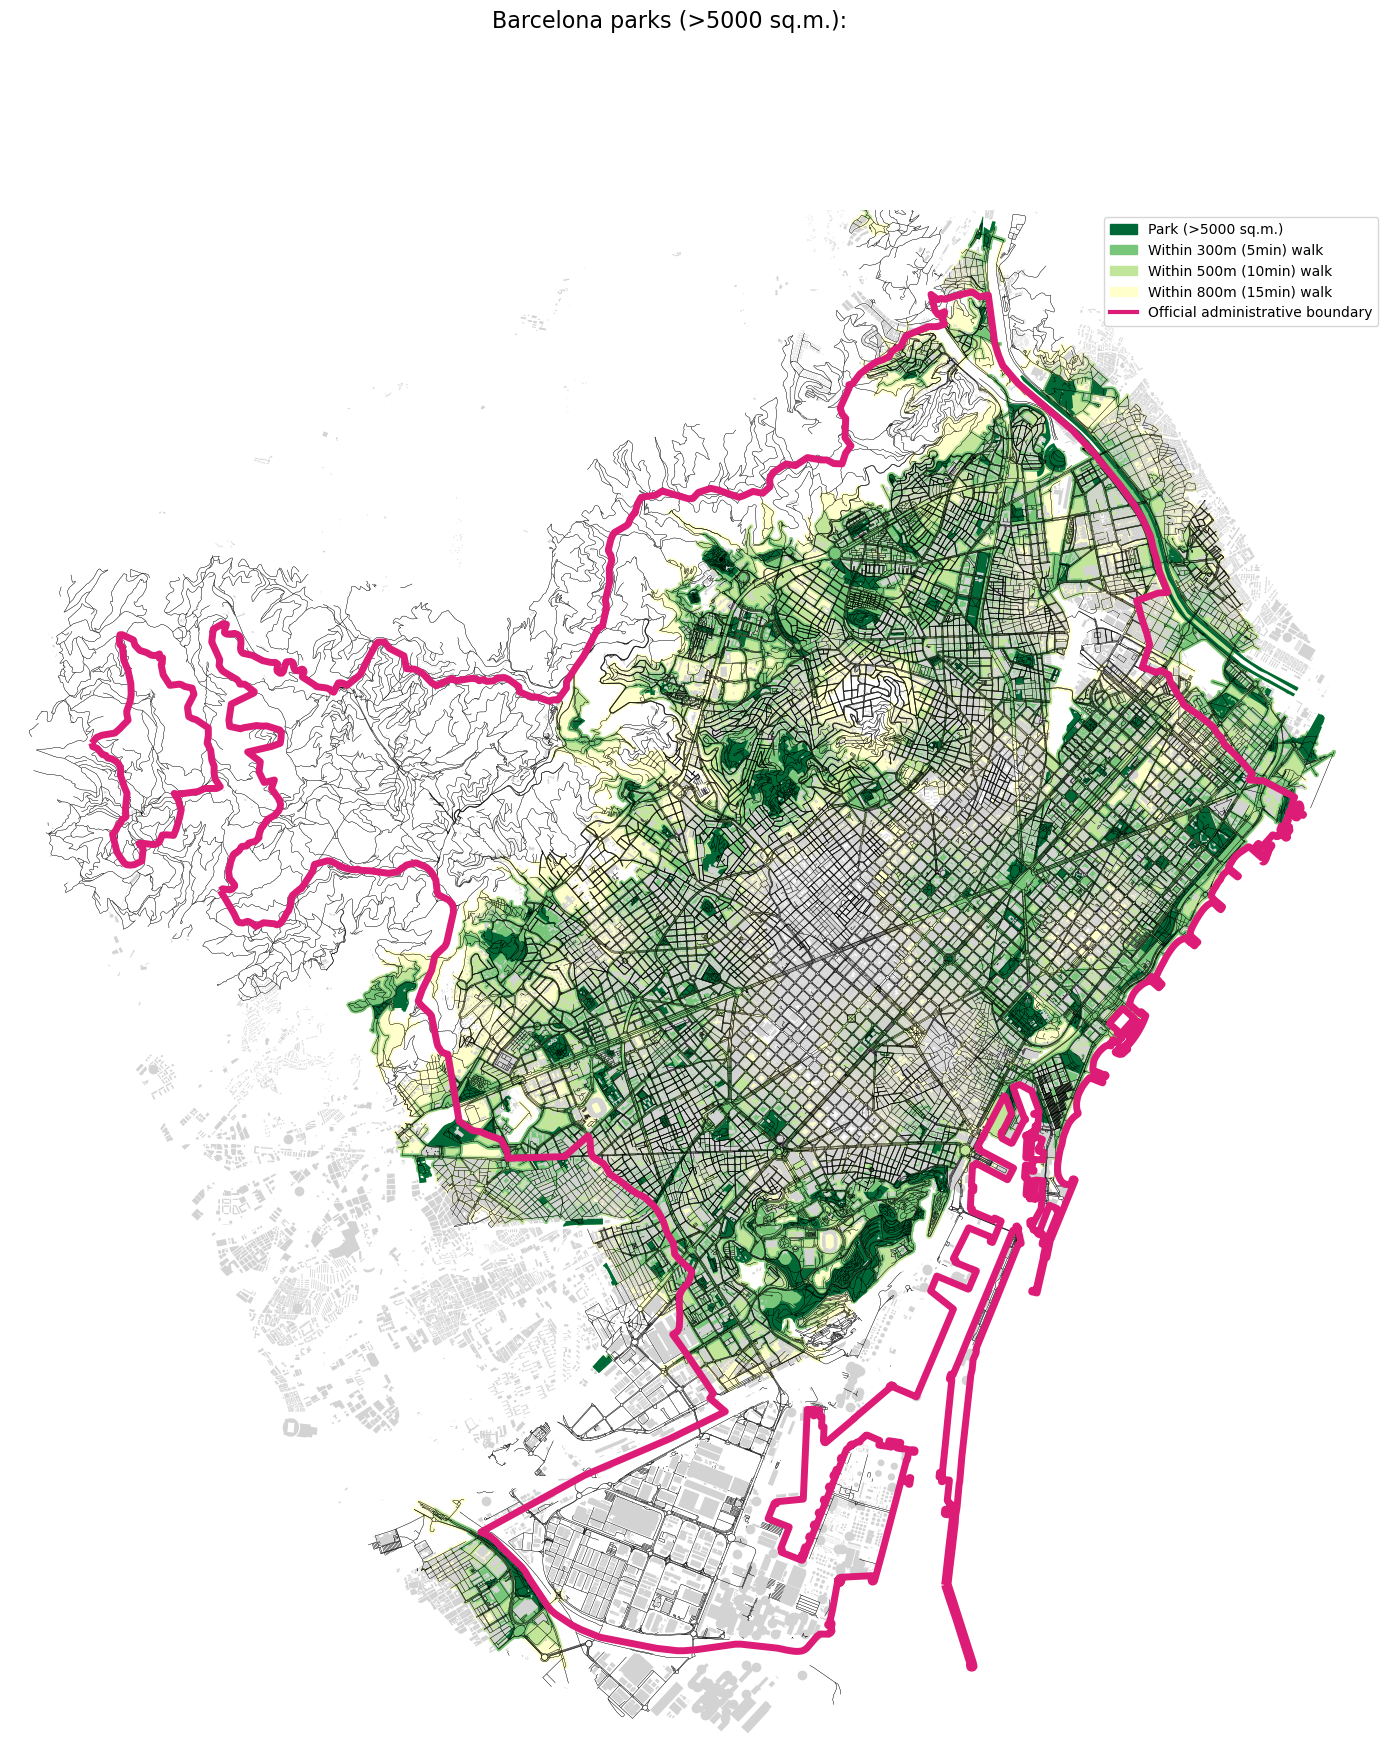

In [14]:
# plot isochrones, parks, buildings, roads, and place boundaries
# include legend and set plot area based on place boundaries
# or - in case of Goteborg - set custom plot area (i.e. clipping of water areas)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('{0} parks (>{1} sq.m.): '.format(place_name, min_area), fontsize=16)

for i in range(len(trip_distances)):
    parks.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs, color=trip_colors[i], zorder=len(trip_distances)-i)
parks.plot(ax=axs, figsize=(12, 20), color='#006837', zorder=4)
buildings.plot(ax=axs, figsize=(12, 12), color='lightgrey', zorder=5)
paths.plot(ax=axs, figsize=(12, 20), color='black', linewidth=0.2, zorder=5)
place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=6)

plt.legend(handles=legend_handles, loc='upper right')

if place_name != 'Goteborg':
    bbox = place.total_bounds
    margin = 1000
    xlim = ([bbox[0]-margin, bbox[2]+margin])
    ylim = ([bbox[1]-margin, bbox[3]+margin])
elif place_name == 'Goteborg':
    xlim = ([310000, 330000])
    ylim = ([6390000, 6410000])
    
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()